# Natural Language Processing with Disaster Tweets

GitHub Repository: https://github.com/niju789/NLP-Disaster-Tweets

## 1 - Introduction

### 1.1 - Problem

This project aims to develop and train a recurrent neural network (RNN) to classify tweets based on whether the tweet is about real disasters.

### 1.2 - Data

The data provided includes two CSV files, one of which is the training set and the other is the testing set. The training set contains 7,613 rows and the testing set contains 3,263 rows. Both sets contain the columns "id", "keyword", "location", and "text". The training set contains the additional column "target" where the value for each row is 1 if the tweet is about a real disaster and 0 otherwise.

## 2 - Exploratory Data Analysis (EDA)

### 2.1 - Data Inspection

#### 2.1.1 - File/Table Structure

In [1]:
import pandas as pd

# Load training and testing sets
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

In [2]:
# Show first 5 rows of training set
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
# Show first 5 rows of testing set
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


#### 2.1.2 - Samples by Classification

Sample tweets for class 0 (not a real disaster).

In [4]:
# Print the "text" value of the first 5 samples where "target" is 0
for i in range(5):
    print(train[train['target'] == 0]['text'].iloc[i])
    print('===')

What's up man?
===
I love fruits
===
Summer is lovely
===
My car is so fast
===
What a goooooooaaaaaal!!!!!!
===


Sample tweets for class 1 (real disaster).

In [5]:
# Print the "text" value of the first 5 samples where "target" is 1
for i in range(5):
    print(train[train['target'] == 1]['text'].iloc[i])
    print('===')

Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
===
Forest fire near La Ronge Sask. Canada
===
All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
===
13,000 people receive #wildfires evacuation orders in California 
===
Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school 
===


### 2.2 - Data Cleaning

#### 2.2.1 - Missing Values

The "keyword" and "location" columns of both the training and testing sets are expected to have missing values. On the other hand, the "id", "text", and "target" columns should not have any missing values.

In [6]:
# Show number of missing values for each column in training set
train.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [7]:
# Show number of missing values for each column in testing set
test.isna().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

#### 2.2.2 - Valid Values

The "target" column in the training set should only contain the values 0 and 1.

In [8]:
# Print the unique values in the "target" column of the training set
print(train['target'].unique())

[1 0]


#### 2.2.3 - Data Cleaning Summary

The "id" and "text" columns in both sets and the "target" column in the training set do not contain any missing values. Additionally, the "target" column in the training set only contains the values 0 and 1 as expected. Therefore, the data is clean to use.

### 2.3 - Data Visualization

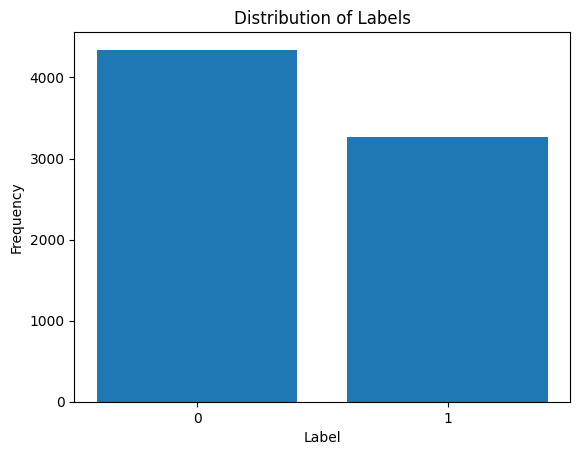

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Get the unique "target" values and their counts
values, counts = np.unique(train['target'], return_counts=True)

plt.bar(values.astype(str), counts)
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.title('Distribution of Labels')
plt.show()

The distribution of labels for tweets in the training set is slightly uneven. However, given that there are thousands of samples of each class, this should not be an issue.

### 2.4 - Plan of Analysis

Based on the EDA, there is no need to significantly alter the usual process for text classification. Of course, a word embedding method would need to be used to represent the words/characters in the tweet numerically for the purpose of classification.

## 3 - Model Architecture

### 3.1 - Word Embedding

The Term Frequency - Inverse Document Frequency (TF-IDF) method will be used to extract the text from the tweets into a feature matrix. TF-IDF caculates the importance of a word in a document based on the number of times the word appears in the document and the number of documents the word appears in from the collection of documents. The reasoning for choosing this extraction method is that it gives more weight to words that are rare across all documents but appear more frequently in one document and less weight to words that appear frequently in every document.

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(ngram_range=(1,2), stop_words='english')
X = tfidf.fit_transform(train['text']).toarray()
X.shape

(7613, 73894)

### 3.2 - Architectures Considered

#### 3.2.1 - Base Architecture

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout

def create_base_model():
    model = Sequential([
        SimpleRNN(units=32, activation='relu', input_shape=(1, X.shape[1])),
        Dense(16, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

create_base_model().summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 32)                2365664   
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 2,366,209
Trainable params: 2,366,209
Non-trainable params: 0
_________________________________________________________________


The model takes as input an array of size 1 x 73,894. The first "layer" is a simple RNN with 32 neurons. The ReLU activation function is used after this RNN layer to introduce non-linearity. This is followed by a fully connected layer of 16 neurons. The ReLU activation function is used again following this layer. A dropout layer is then used to help reduce any overfitting by dropping 20% of the neurons in the model so far. The output layer uses the Sigmoid activation function since this is a binary classification problem where the output should be between 0 and 1. 

#### 3.2.2 - Long Short-Term Memory (LSTM)

In [12]:
from tensorflow.keras.layers import LSTM

def create_lstm_model():
    model = Sequential([
        LSTM(units=32, activation='relu', input_shape=(1, X.shape[1])),
        Dense(16, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

create_lstm_model().summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                9462656   
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 9,463,201
Trainable params: 9,463,201
Non-trainable params: 0
_________________________________________________________________


This architecture is similar to the base architecture, but the only difference being that this architecture uses an RNN with LSTM instead of a simple RNN.

#### 3.2.3 - Gated Recurrent Unit (GRU)

In [13]:
from tensorflow.keras.layers import GRU

def create_gru_model():
    model = Sequential([
        GRU(units=32, activation='relu', input_shape=(1, X.shape[1])),
        Dense(16, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

create_gru_model().summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 32)                7097088   
                                                                 
 dense_4 (Dense)             (None, 16)                528       
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 7,097,633
Trainable params: 7,097,633
Non-trainable params: 0
_________________________________________________________________


This architecture is similar to the base architecture, but the only difference being that this architecture uses an RNN with GRUs instead of a simple RNN.

### 3.3 - Hyperparameters

Due to limited resources in terms of computing power and time, the hyperparameters that will be considered are those involved in training a neural network.

The hyperparameters that will be tuned are:
- Number of epochs
- Batch size

## 4 - Results and Analysis

### 4.1 - Hyperparameter Tuning

The hyperparameter tuning procedure will consider 10 and 20 as values for the number of epochs and 64, 128, and 256 as values for the batch size.

In [14]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

# Split the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, train['target'].values, test_size=0.2, random_state=123)

# Reshape the input to match RNN input requirements
X_train = np.expand_dims(X_train, axis=1)
X_val = np.expand_dims(X_val, axis=1)

# Hyperparameters and values considered
num_epochs = [10, 20]
batch_sizes = [64, 128, 256]

# Returns best # of epochs, batch size, validation accuracy, and model
def tune_hyperparameters(create_model):
    val_accs = {}
    best_val_acc = 0
    best_h_params = { 'num_epochs': None, 'batch_size': None }
    best_hp_model = None
    
    for epochs in num_epochs:
        val_accs[epochs] = {}
        for batch_size in batch_sizes:
            print(f'# of epochs: {epochs}, batch size: {batch_size}')
            model = create_model()
            early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
            history = model.fit(
                X_train, y_train,
                validation_data=(X_val, y_val),
                epochs=epochs,
                batch_size=batch_size,
                callbacks=[early_stopping],
                verbose=0
            )
            val_acc = max(history.history['val_accuracy'])
            print(f'Validation accuracy: {val_acc}')
            val_accs[epochs][batch_size] = val_acc
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_h_params['num_epochs'] = epochs
                best_h_params['batch_size'] = batch_size
                best_hp_model = model
                
    return val_accs, best_val_acc, best_h_params, best_hp_model

In [15]:
base_val_accs, base_best_val_acc, base_best_h_params, base_best_hp_model = tune_hyperparameters(create_base_model)

# of epochs: 10, batch size: 64
Validation accuracy: 0.810899555683136
# of epochs: 10, batch size: 128
Validation accuracy: 0.8154957294464111
# of epochs: 10, batch size: 256
Validation accuracy: 0.7905449867248535
# of epochs: 20, batch size: 64
Validation accuracy: 0.7951411604881287
# of epochs: 20, batch size: 128
Validation accuracy: 0.8010505437850952
# of epochs: 20, batch size: 256
Validation accuracy: 0.8049901723861694


In [16]:
print(f'Best validation accuracy: {base_best_val_acc}')
print(f'Best number of epochs: {base_best_h_params["num_epochs"]}')
print(f'Best batch size: {base_best_h_params["batch_size"]}')

Best validation accuracy: 0.8154957294464111
Best number of epochs: 10
Best batch size: 128


The base architecture model trained with a batch size of 128 over 10 epochs gave the best validation accuracy.

### 4.2 - Techniques to Improve Training or Performance

Using the architectures that use LSTM and GRU, it may be possible to train a model with better performance. Hyperparameter tuning will be performed similar to that of the base architecture with the same hyperparameters and values considered.

#### 4.2.1 - LSTM Architecture

In [17]:
lstm_val_accs, lstm_best_val_acc, lstm_best_h_params, lstm_best_hp_model = tune_hyperparameters(create_lstm_model)

# of epochs: 10, batch size: 64
Validation accuracy: 0.8043335676193237
# of epochs: 10, batch size: 128
Validation accuracy: 0.8056467771530151
# of epochs: 10, batch size: 256
Validation accuracy: 0.7839789986610413
# of epochs: 20, batch size: 64
Validation accuracy: 0.7977675795555115
# of epochs: 20, batch size: 128
Validation accuracy: 0.8030203580856323
# of epochs: 20, batch size: 256
Validation accuracy: 0.780039370059967


In [18]:
print(f'Best validation accuracy: {lstm_best_val_acc}')
print(f'Best number of epochs: {lstm_best_h_params["num_epochs"]}')
print(f'Best batch size: {lstm_best_h_params["batch_size"]}')

Best validation accuracy: 0.8056467771530151
Best number of epochs: 10
Best batch size: 128


The LSTM architecture model trained with a batch size of 128 over 10 epochs gave the best validation accuracy.

#### 4.2.2 - GRU Architecture

In [19]:
gru_val_accs, gru_best_val_acc, gru_best_h_params, gru_best_hp_model = tune_hyperparameters(create_gru_model)

# of epochs: 10, batch size: 64
Validation accuracy: 0.8063033223152161
# of epochs: 10, batch size: 128
Validation accuracy: 0.803676962852478
# of epochs: 10, batch size: 256
Validation accuracy: 0.8023637533187866
# of epochs: 20, batch size: 64
Validation accuracy: 0.8063033223152161
# of epochs: 20, batch size: 128
Validation accuracy: 0.8030203580856323
# of epochs: 20, batch size: 256
Validation accuracy: 0.7938279509544373


In [20]:
print(f'Best validation accuracy: {gru_best_val_acc}')
print(f'Best number of epochs: {gru_best_h_params["num_epochs"]}')
print(f'Best batch size: {gru_best_h_params["batch_size"]}')

Best validation accuracy: 0.8063033223152161
Best number of epochs: 10
Best batch size: 64


The GRU architecture model trained with a batch size of 64 over 10 epochs gave the best validation accuracy.

### 4.3 - Results

#### 4.3.1 - Base Architecture

In [21]:
base_val_accs

{10: {64: 0.810899555683136, 128: 0.8154957294464111, 256: 0.7905449867248535},
 20: {64: 0.7951411604881287,
  128: 0.8010505437850952,
  256: 0.8049901723861694}}

Hyperparameter tuning results for number of epochs and batch size for base architecture:

|| 64 Batch Size | 128 Batch Size | 256 Batch Size |
| :-: | :-: | :-: | :-: |
| **10 Epochs** | 0.811 | 0.815 | 0.791 |
| **20 Epochs** | 0.795 | 0.801 | 0.805 |

#### 4.3.2 - LSTM Architecture

In [22]:
lstm_val_accs

{10: {64: 0.8043335676193237,
  128: 0.8056467771530151,
  256: 0.7839789986610413},
 20: {64: 0.7977675795555115, 128: 0.8030203580856323, 256: 0.780039370059967}}

Hyperparameter tuning results for number of epochs and batch size for LSTM architecture:

|| 64 Batch Size | 128 Batch Size | 256 Batch Size |
| :-: | :-: | :-: | :-: |
| **10 Epochs** | 0.804 | 0.806 | 0.784 |
| **20 Epochs** | 0.798 | 0.803 | 0.780 |

#### 4.3.3 - GRU Architecture

In [23]:
gru_val_accs

{10: {64: 0.8063033223152161, 128: 0.803676962852478, 256: 0.8023637533187866},
 20: {64: 0.8063033223152161,
  128: 0.8030203580856323,
  256: 0.7938279509544373}}

Hyperparameter tuning results for number of epochs and batch size for GRU architecture:

|| 64 Batch Size | 128 Batch Size | 256 Batch Size |
| :-: | :-: | :-: | :-: |
| **10 Epochs** | 0.806 | 0.804 | 0.802 |
| **20 Epochs** | 0.806 | 0.803 | 0.794 |

#### 4.3.4 - Summary

Best accuracies achieved across architectures:

| Architecture | Best Validation Accuracy |
| :-: | :-: |
| Base | 0.815 |
| LSTM | 0.806 |
| GRU | 0.806 |

### 4.4 - Analysis

The best validation accuracy obtained through hyperparameter tuning for the base architecture was 0.815. The best validation accuracies obtained for both the LSTM and GRU architectures were lower than the one for the base architecture. Despite LSTM and GRU having advantages over the base model, the lower validation accuracies for these models could indicate overfitting.

### 4.5 - Test Data Prediction

Creating the submission file for the Natural Language Processing with Disaster Tweets competition using the best base model obtained after hyperparameter tuning.

In [24]:
X_test = tfidf.transform(test['text']).toarray()
X_test = np.expand_dims(X_test, axis=1)

predictions = base_best_hp_model.predict(X_test)
pred_labels = (predictions > 0.5).astype(int).reshape(-1)

output = pd.DataFrame({'id': test['id'], 'target': pred_labels})
output.to_csv('output.csv', index=False)

102/102 [==============================] - 1s 5ms/step


The F1 score on the testing set was 0.794.

## 5 - Conclusion

In this project, an RNN was developed and trained with the goal of being able to classify whether a tweet is about a real disaster or not. Three different architectures were considered and compared. Based on hyperparameter tuning results, the model with the base architecture had better performance and the best number of epochs was 10 and the best batch size was 128. This gave a validation accuracy of 0.815.

Two techniques to help improve the performance of the model were considered: LSTM and GRU. Using the LSTM architecture did not help improve performance since the best validation accuracy obtained was 0.806. Similarly, using the GRU architecture did not help improve performance since the best validation accuracy obtained was also 0.806. Based on these results, it is possible that these two techniques did not help since the model is overfitting.

Some possible improvements to try in the future include decreasing the model complexity and trying different techniques to help improve performance. The models may be overfitting, so experimenting with different techniques that help reduce overfitting may be useful.